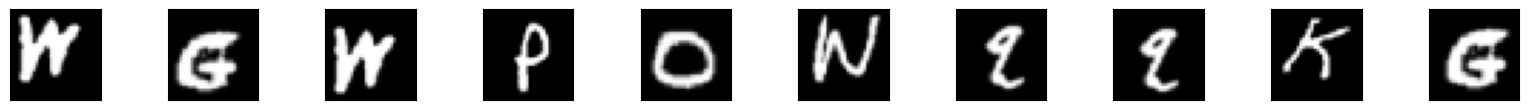

In [205]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

loaded_images = utils.load_images_from_zip()
emnist_data, emnist_labels = utils.load_true_emnist()

utils.plot_images(loaded_images[:10])


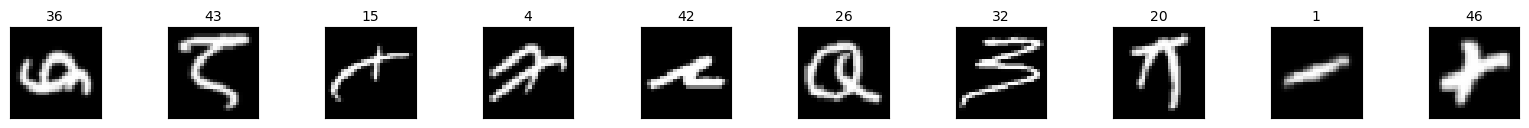

In [206]:
utils.plot_images(emnist_data[:10], base_dim=28, labels=emnist_labels[:10])   

In [204]:
import importlib
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\User\\Mon Drive\\DSB\\2A HEC\\Unsupervised DL\\denoising_emnist\\utils.py'>

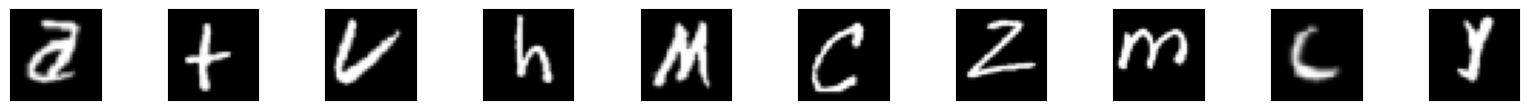

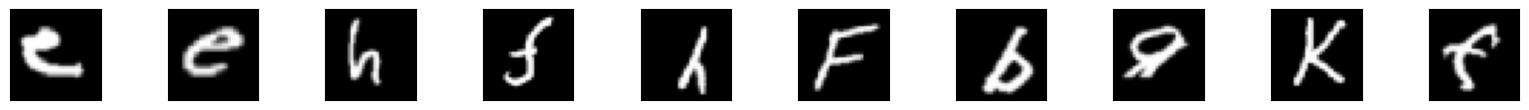

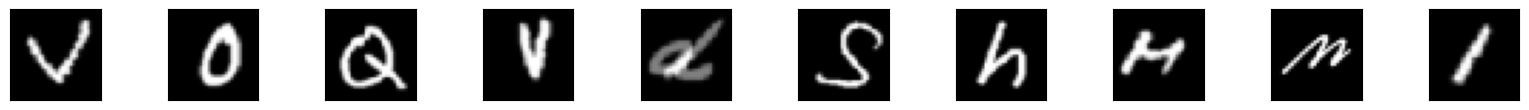

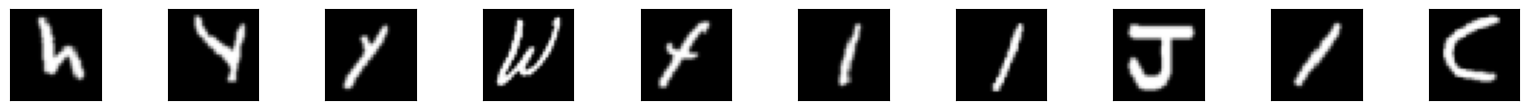

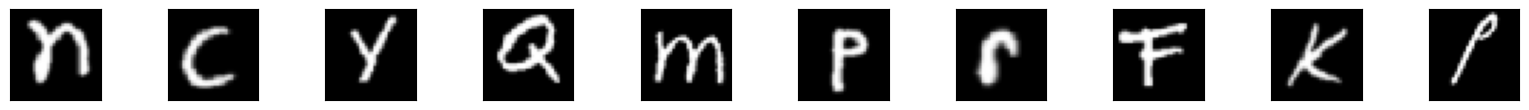

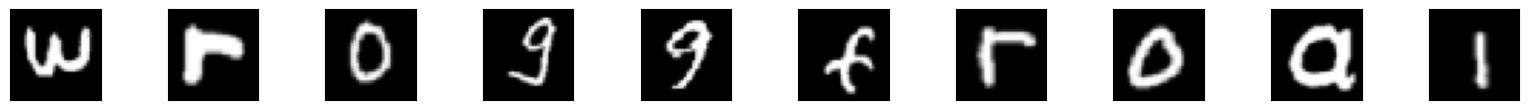

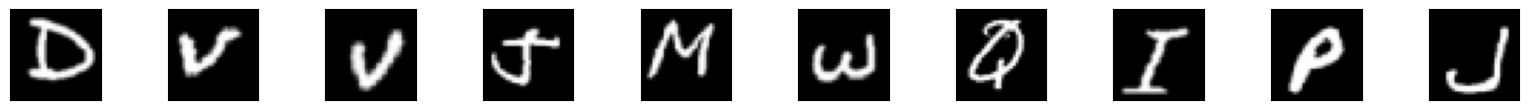

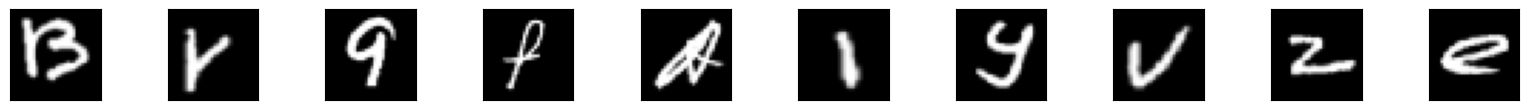

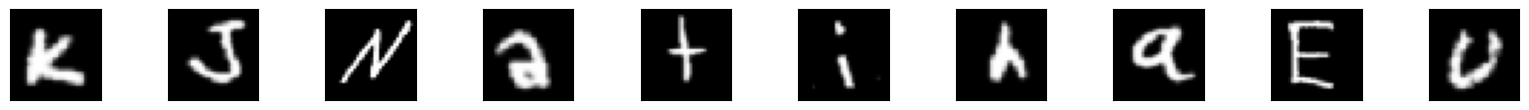

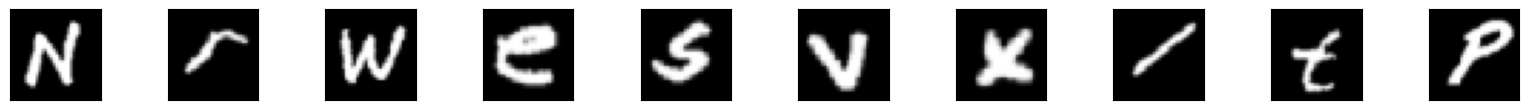

In [157]:
indexes = np.random.choice(len(loaded_images), 100, replace=False)
data = torch.tensor(loaded_images[indexes]).float().to(device)
utils.plot_images(data)

We see at least 5 types of corruptions: 

    - white squares
    - reversed colors
    - interpolations between different images
    - noise added

Some images also seem to have undergoned other modifications, but it is possible that these were already in the EMNIST original dataset:

    - inversion
    - rotation

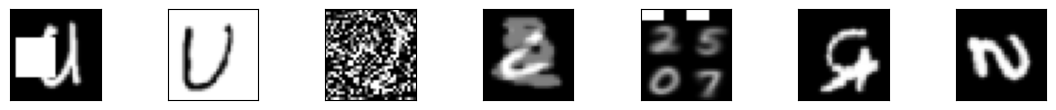

In [192]:
examples_corruptions = [ 80189,  80009,   7577,  59775, 108725, 88270, 119131]
utils.plot_images(loaded_images[examples_corruptions])

# Autoencoder

We build an autoencoder on the corrupted data. Our hope is that we will be able to identify the corrupted instances with the reconstruction loss.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.optim as optim

loaded_images_nn = torch.tensor(
    np.reshape(loaded_images, (len(loaded_images), 32 * 32)), 
    device=device,
    dtype=torch.float32
    )
data_train, data_test = train_test_split(loaded_images_nn, test_size=0.2, random_state=42)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=256, shuffle=False)


Using architecture from [here](https://medium.com/@weidagang/demystifying-anomaly-detection-with-autoencoder-neural-networks-1e235840d879)

In [211]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim=data_train.shape[1]):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x) 
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model = AutoEncoder()
model = model.to(device)

optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

In [42]:
def train_model(model, loss_fn, data_loader=None, epochs=10, optimizer=None):
    model.train()
    for epoch in range(epochs):
        for batch_idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, data)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(data_loader.dataset),
                    100. * batch_idx / len(data_loader), loss.data.item()))


In [43]:
train_model(model, loss_fn, data_loader=train_loader, epochs=10, optimizer=optimizer)

Train Epoch: 0 [0/104845 (0%)]	Loss: 0.224558
Train Epoch: 0 [25600/104845 (24%)]	Loss: 0.069227
Train Epoch: 0 [51200/104845 (49%)]	Loss: 0.059287
Train Epoch: 0 [76800/104845 (73%)]	Loss: 0.054845
Train Epoch: 0 [102400/104845 (98%)]	Loss: 0.051054
Train Epoch: 1 [0/104845 (0%)]	Loss: 0.049646
Train Epoch: 1 [25600/104845 (24%)]	Loss: 0.046790
Train Epoch: 1 [51200/104845 (49%)]	Loss: 0.041047
Train Epoch: 1 [76800/104845 (73%)]	Loss: 0.037411
Train Epoch: 1 [102400/104845 (98%)]	Loss: 0.037713
Train Epoch: 2 [0/104845 (0%)]	Loss: 0.032974
Train Epoch: 2 [25600/104845 (24%)]	Loss: 0.035298
Train Epoch: 2 [51200/104845 (49%)]	Loss: 0.032652
Train Epoch: 2 [76800/104845 (73%)]	Loss: 0.030749
Train Epoch: 2 [102400/104845 (98%)]	Loss: 0.029873
Train Epoch: 3 [0/104845 (0%)]	Loss: 0.030317
Train Epoch: 3 [25600/104845 (24%)]	Loss: 0.028203
Train Epoch: 3 [51200/104845 (49%)]	Loss: 0.028384
Train Epoch: 3 [76800/104845 (73%)]	Loss: 0.028323
Train Epoch: 3 [102400/104845 (98%)]	Loss: 0.027

c:\Users\User\Mon Drive\DSB\2A HEC\Unsupervised DL\denoising_emnist\utils.py:101: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  for i in range(n):


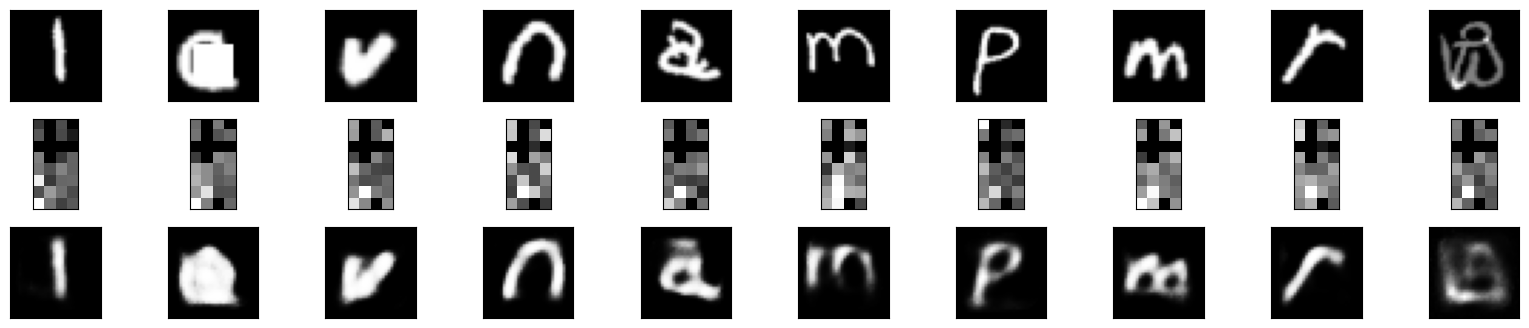

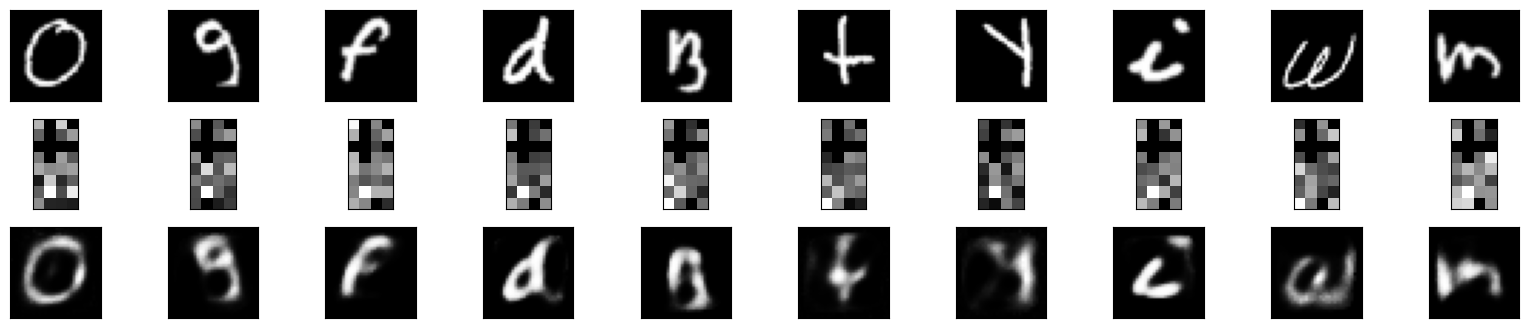

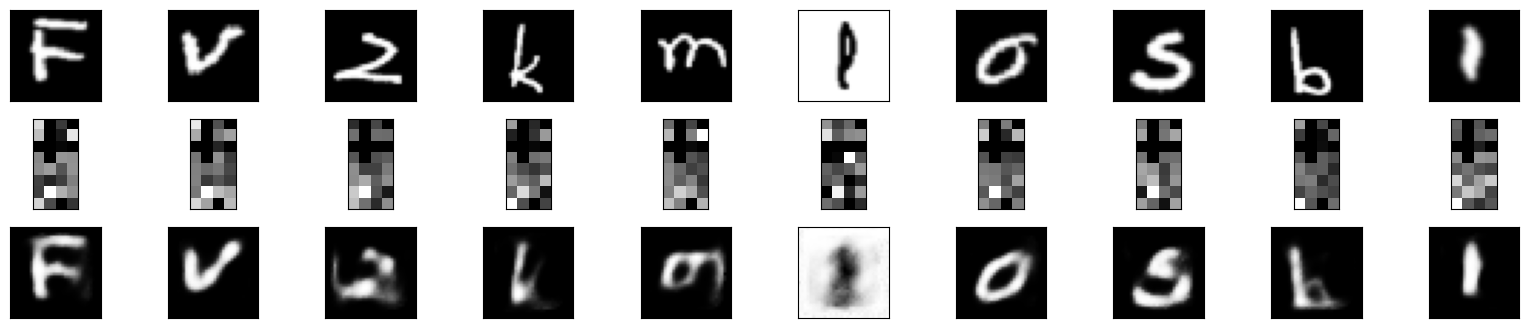

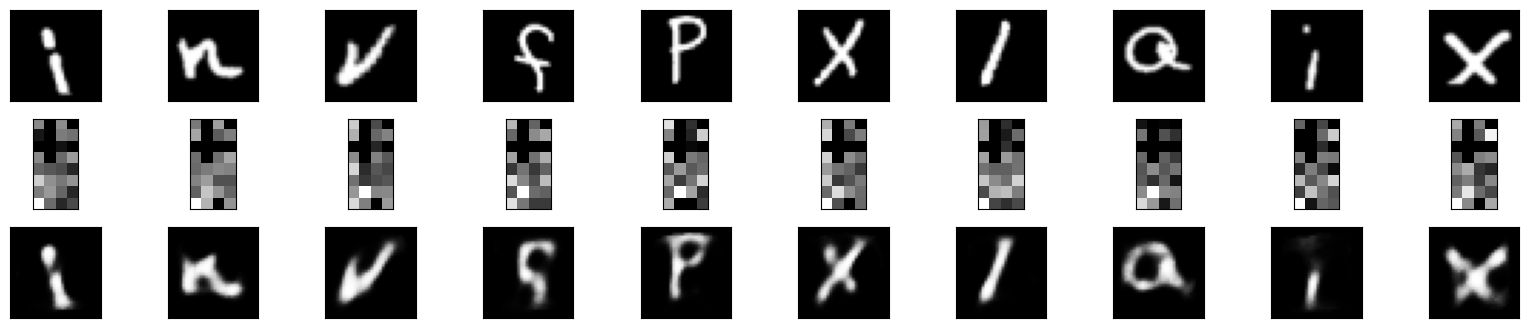

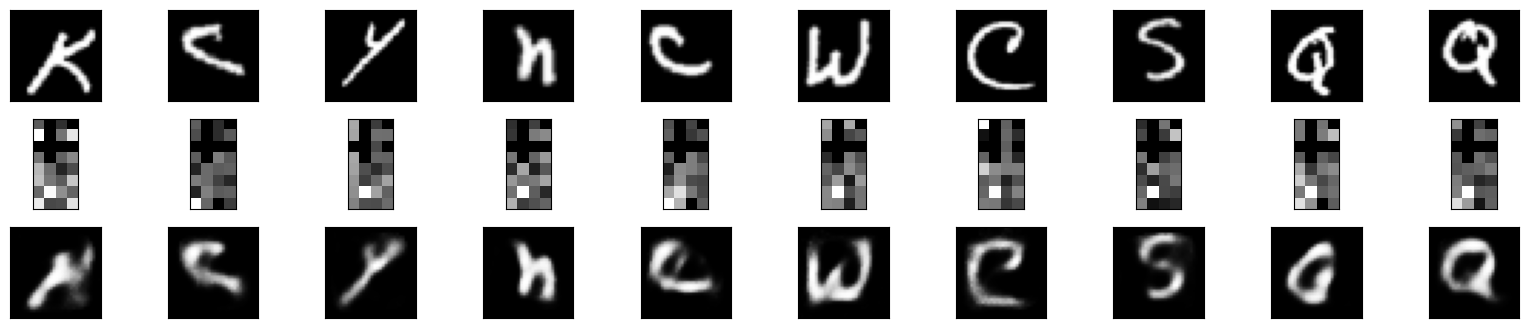

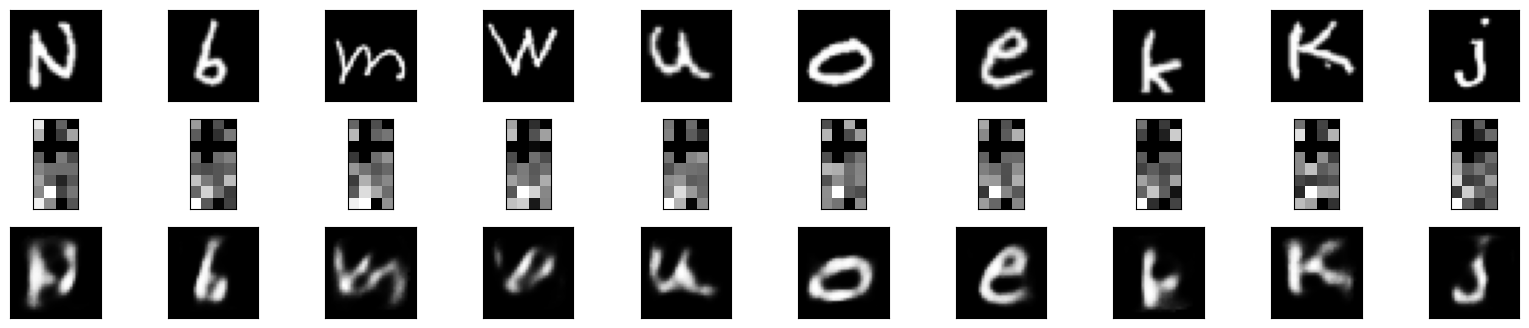

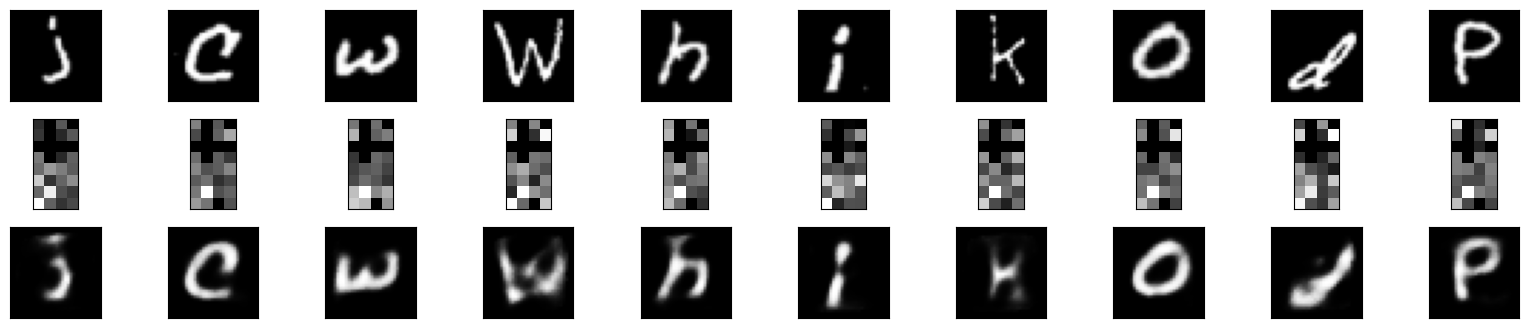

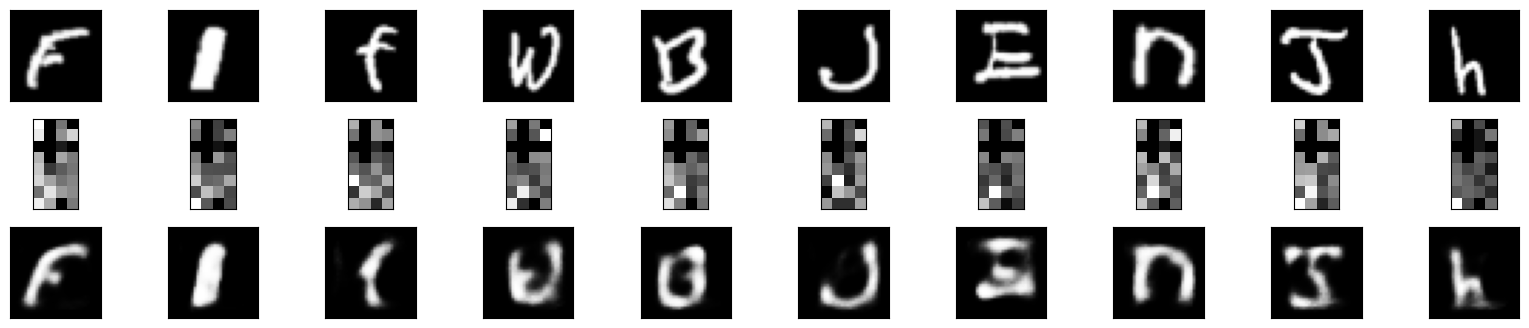

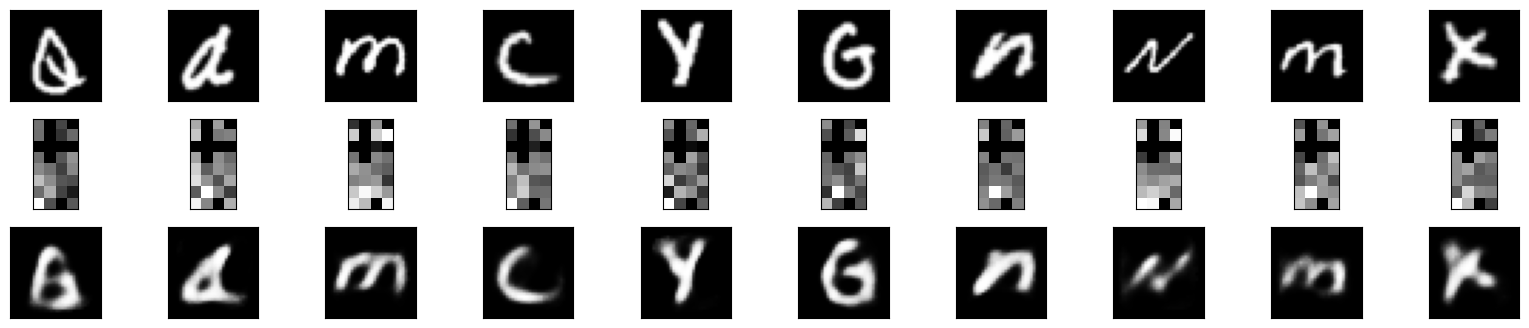

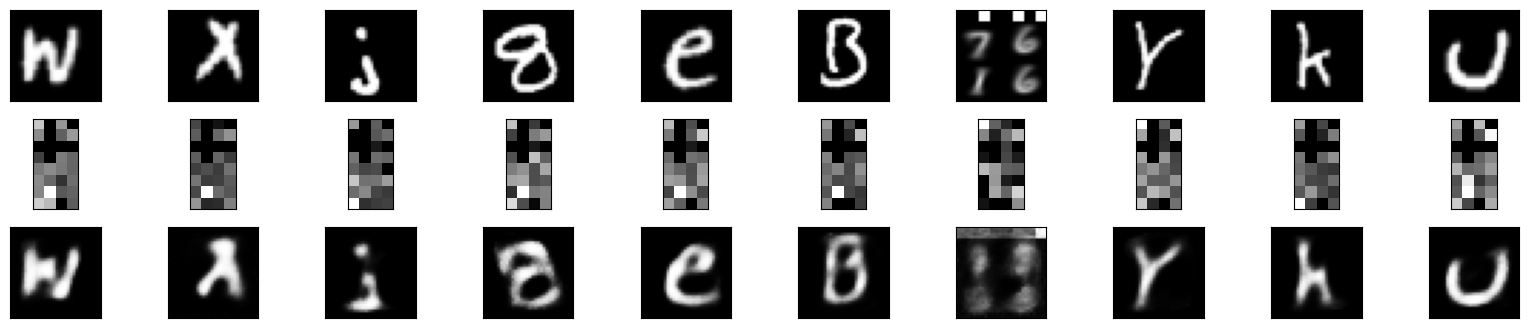

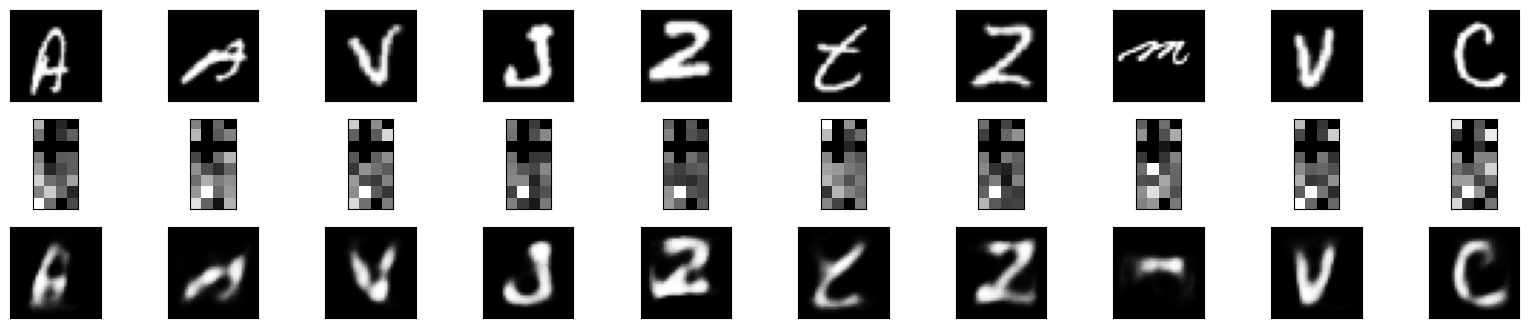

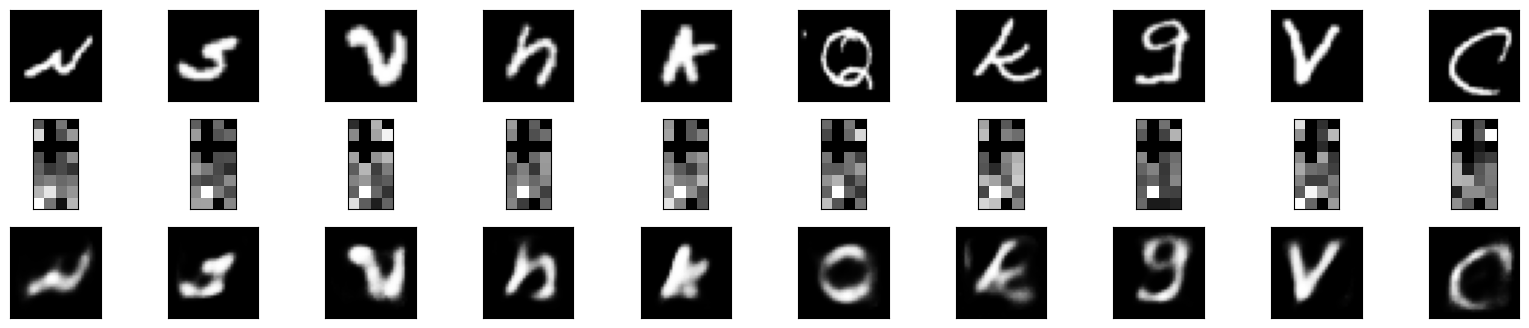

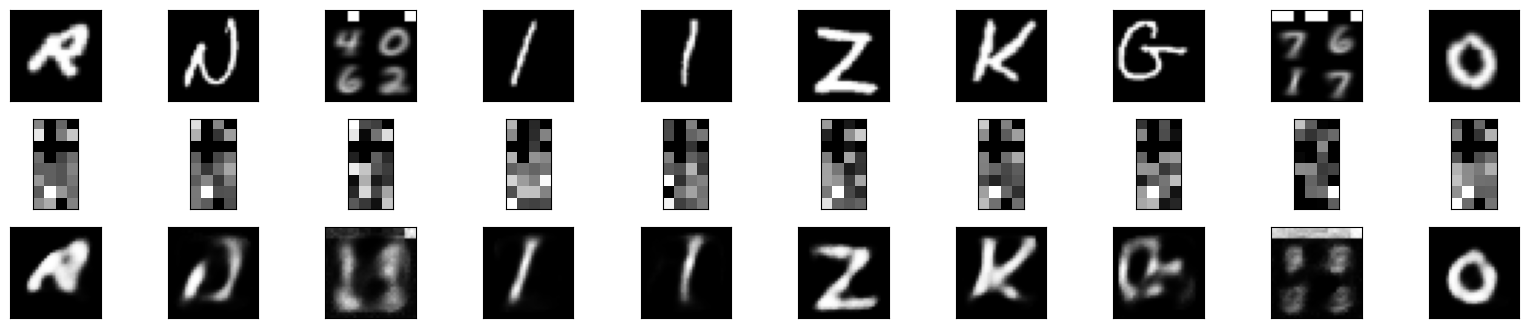

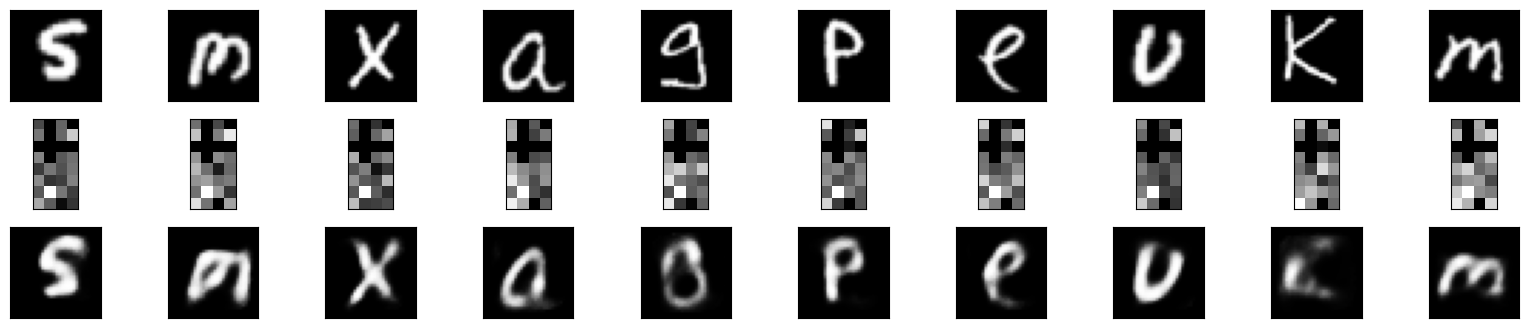

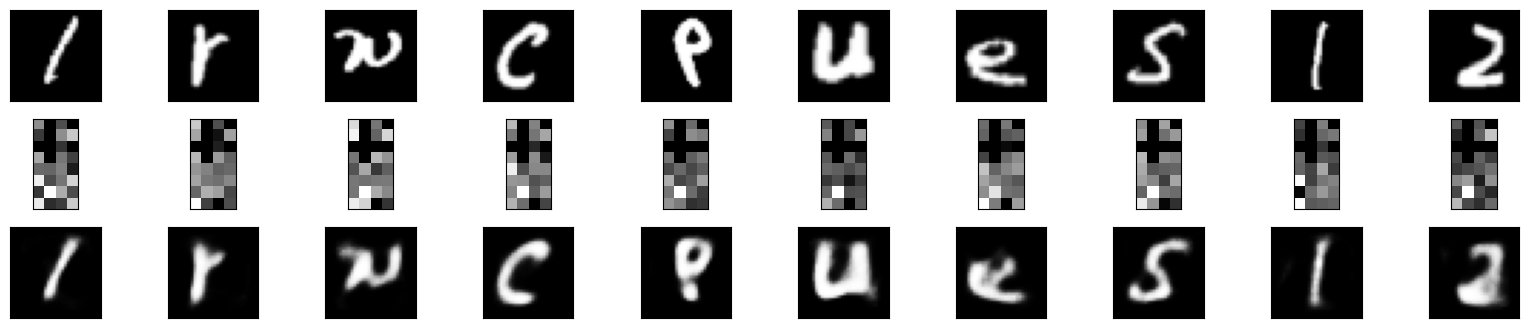

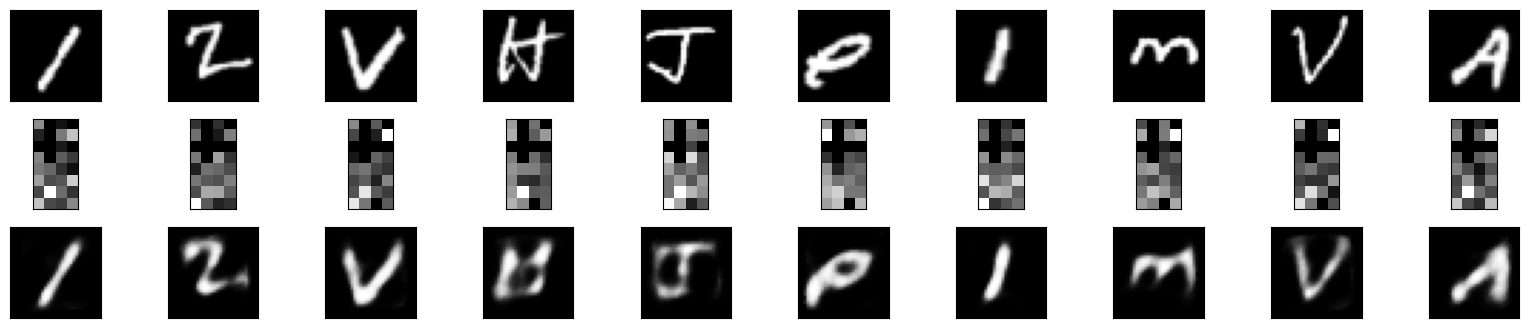

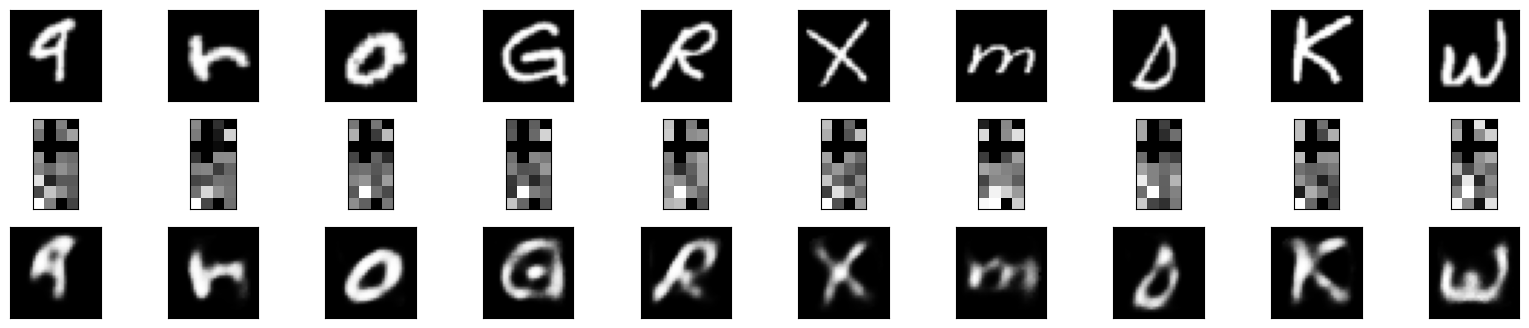

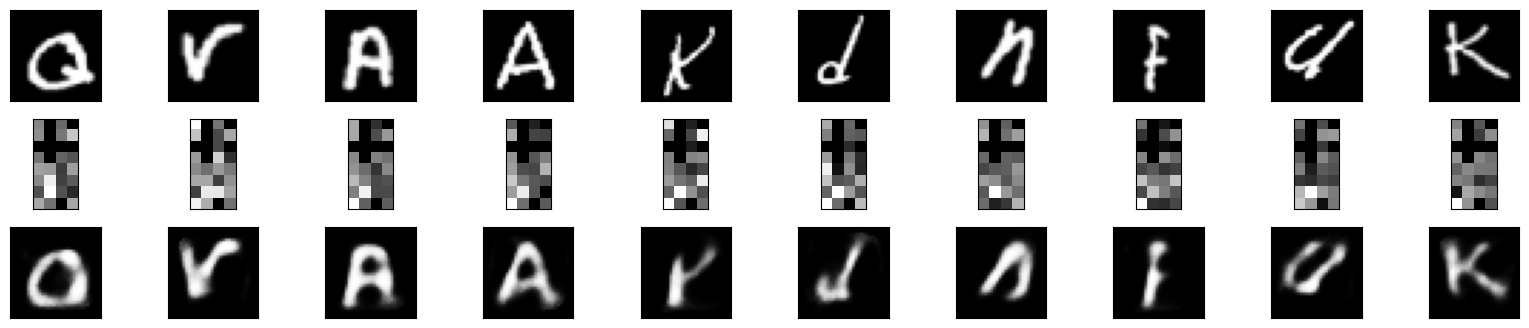

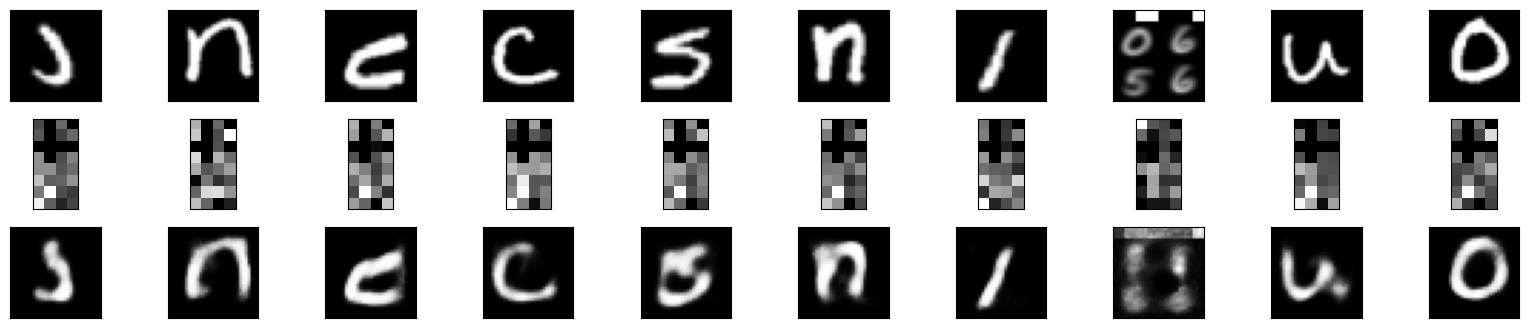

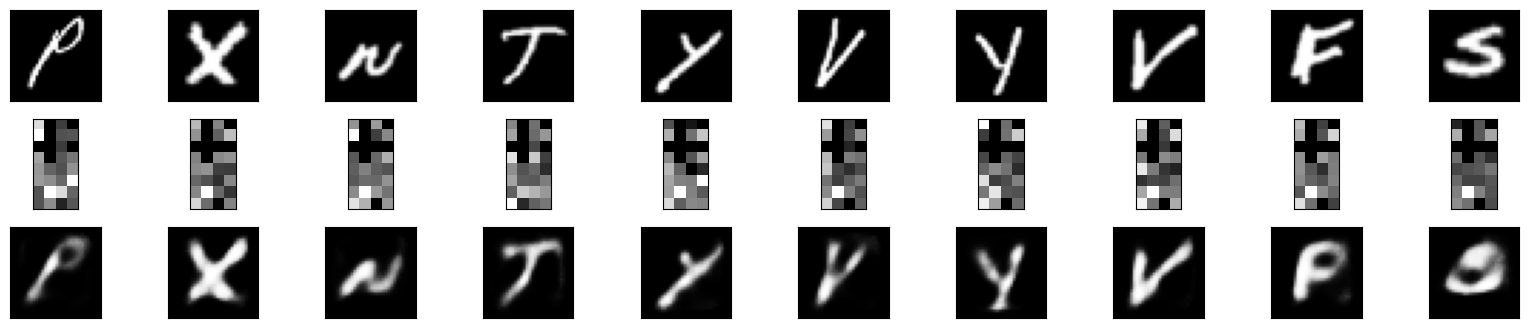

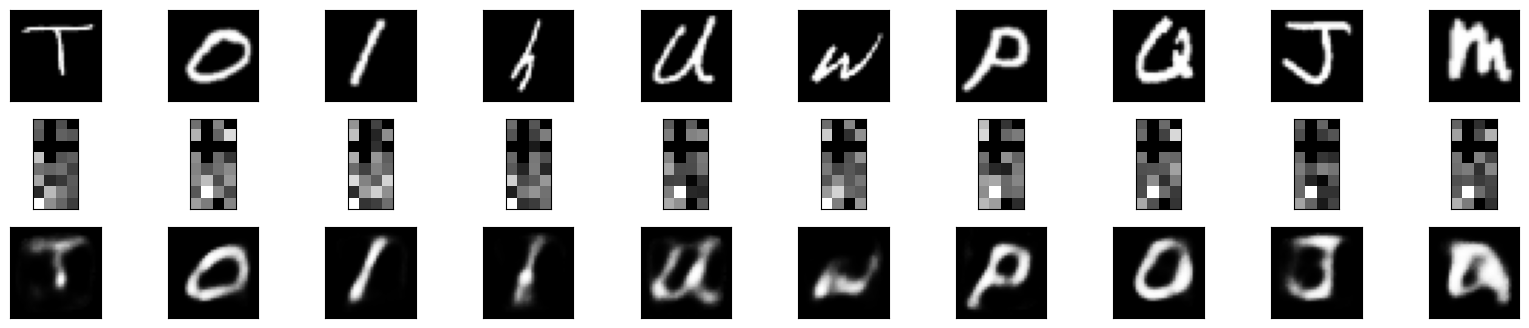

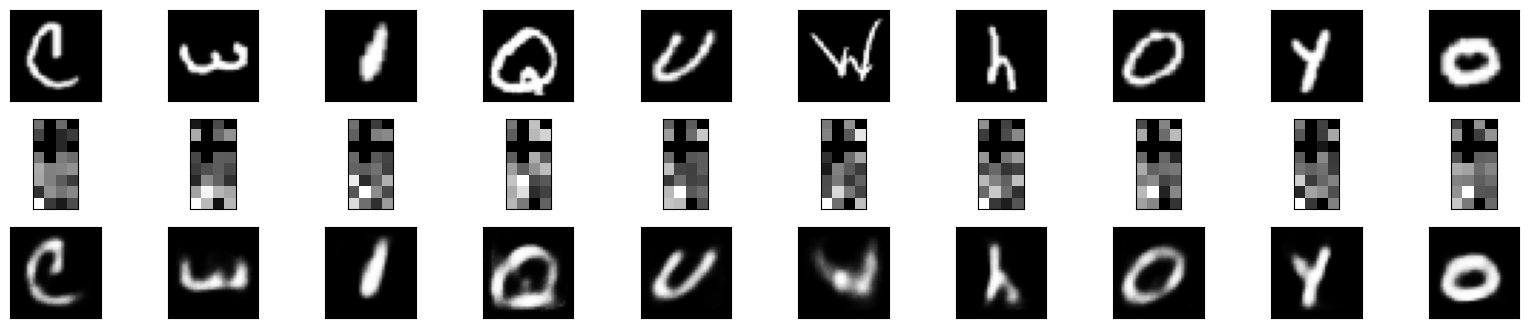

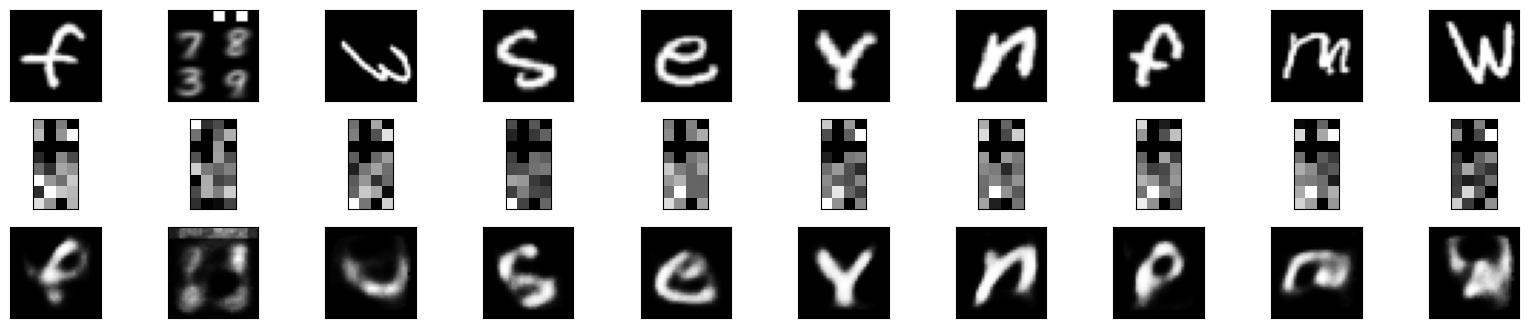

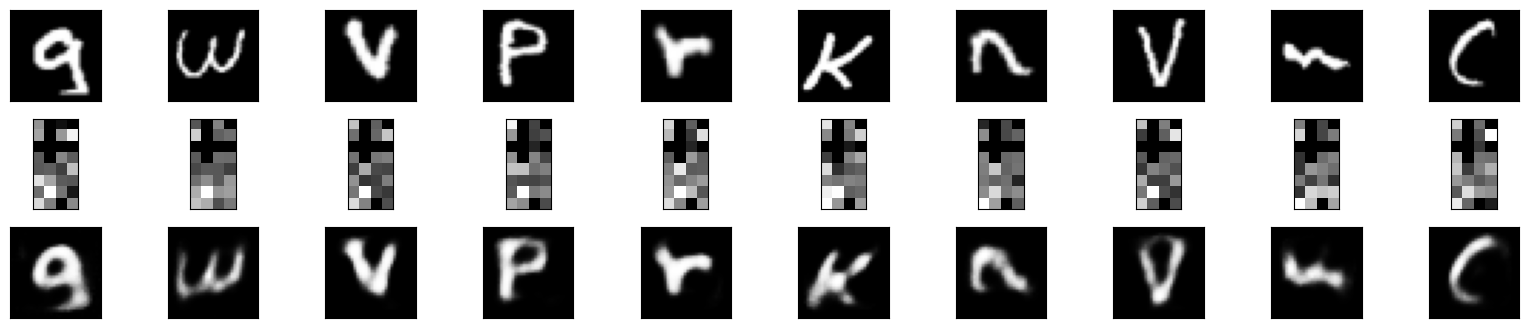

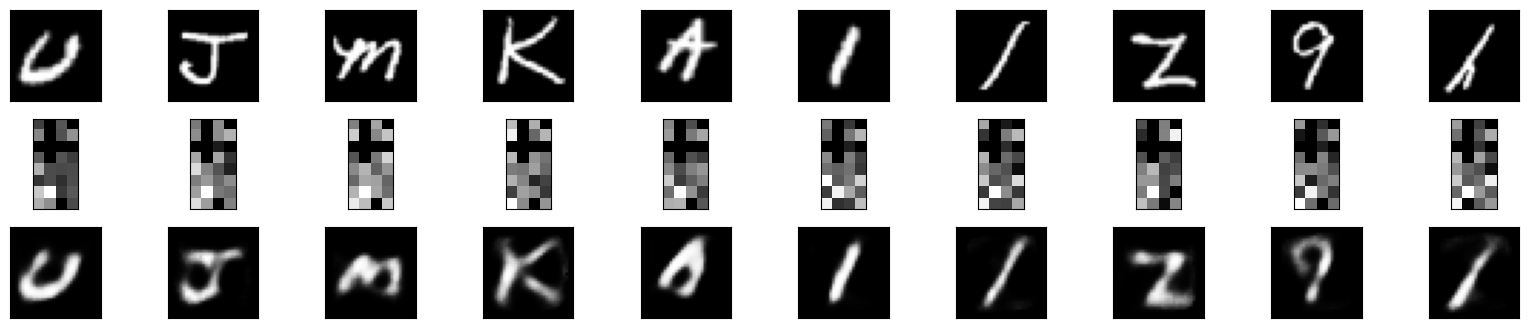

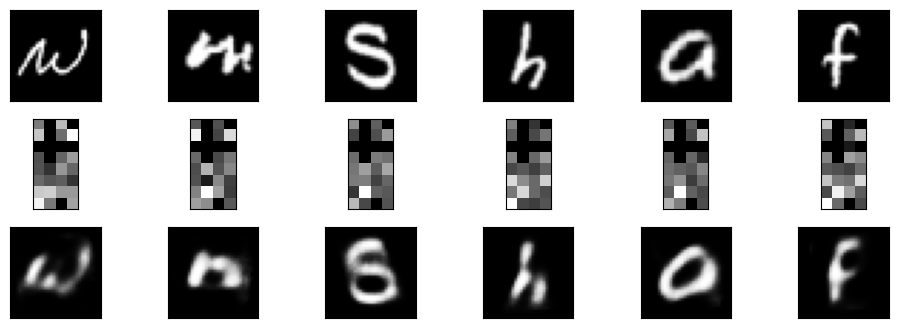

In [195]:
data_viz = next(iter(test_loader))
utils.plot_reconstructions(model, data_viz)

We see that the model is doing well for reconstruction, even when the image is one of the noisy images, for examples in the 3 cases displayed below. This means that the model was able to learn the noise: perhaps because it has too many parameters (and thus flexibility), or because we are using the reconstruction loss against the dataset itself.

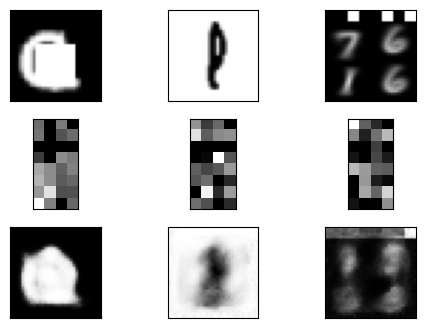

In [199]:
indexes = [1, 25, 96]
utils.plot_reconstructions(model, data[indexes])

Let's isolate the instances with the highest reconstruction loss to see if we can identify the corrupted instances through this method.

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


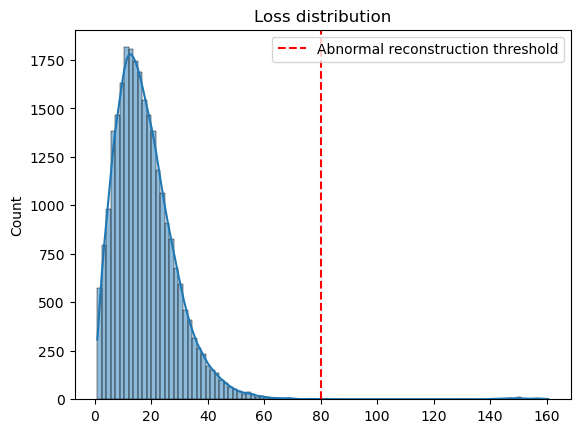

In [200]:
# Visualize the loss distribution

import seaborn as sns

eval_loss = torch.nn.MSELoss(reduction='none')
losses = eval_loss(model(data_test), data_test).sum(axis=1).detach().cpu().numpy()


sns.histplot(losses, bins=100, kde=True)
plt.axvline(x=80, color='r', linestyle='--', label='Abnormal reconstruction threshold')
plt.title('Loss distribution')
plt.legend()
plt.show()

torch.Size([55, 1024])


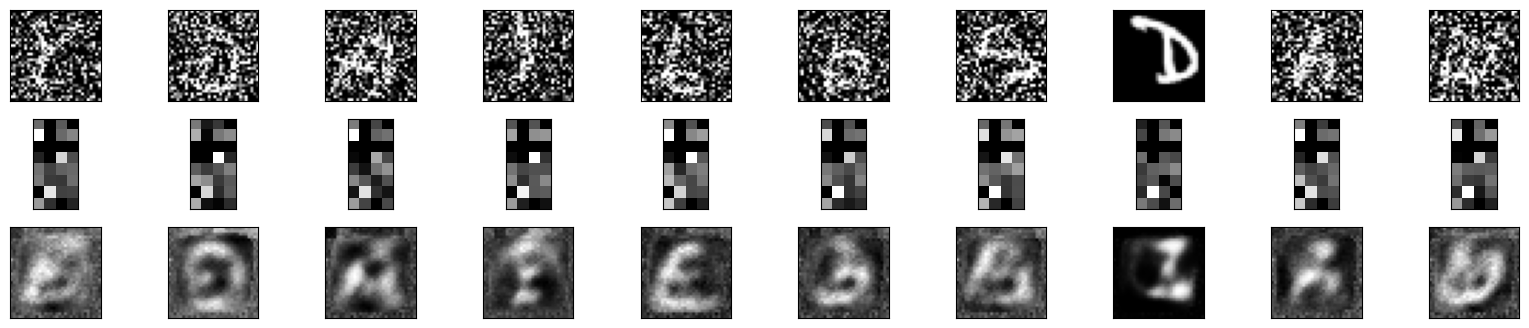

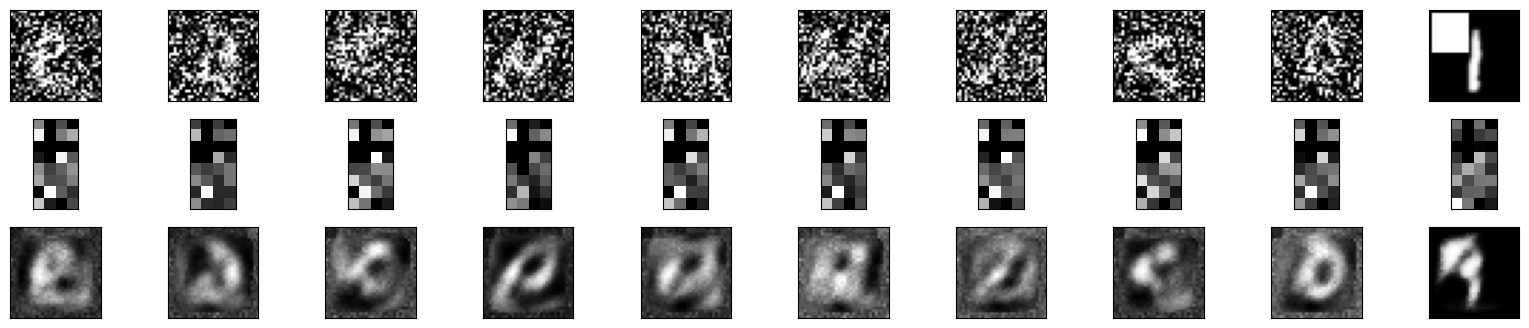

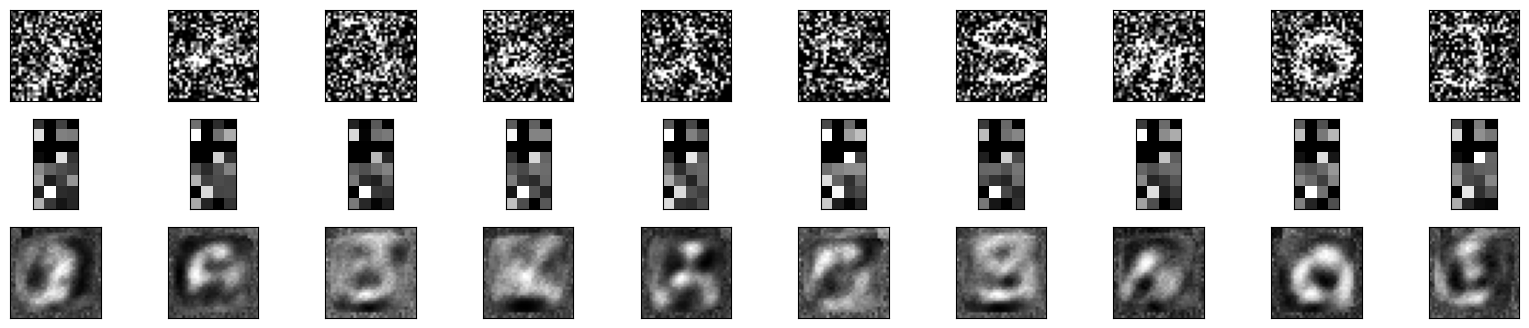

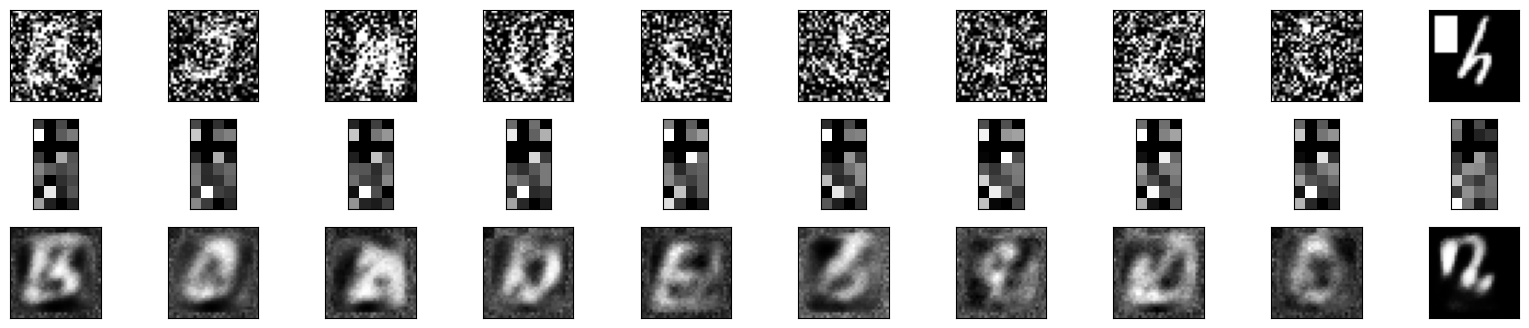

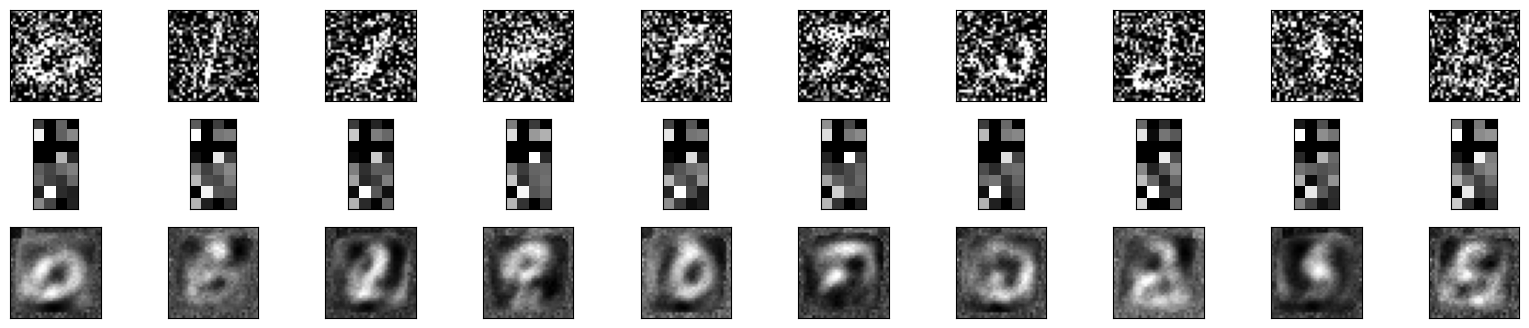

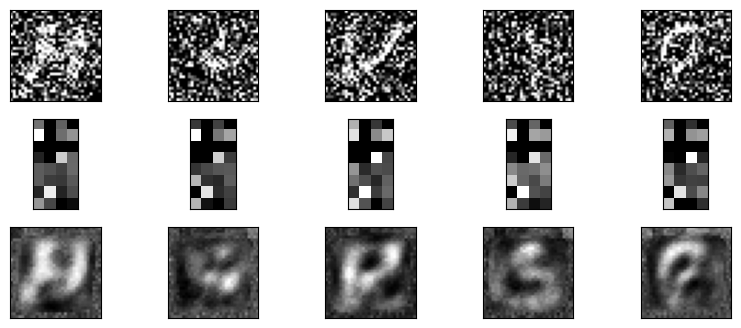

In [202]:
mask = losses > 80
outliers = data_test[mask]
print(outliers.shape)
utils.plot_reconstructions(model, outliers)

Almost all these instances are corrupted images. However, we see that we capture mostly the ones to which noise was added, but not the other corrupted ones (white squares, 4 images together...)

However, given the nature of the corruptions, this approach may not be adapted: the "white square errors" are likely to be hard to identify with reconstruction errors.